In [1]:
%pip -q install timesfm jax seaborn
import timesfm
import pandas as pd
import numpy as np
#Let's Visualise the Datas
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

Note: you may need to restart the kernel to use updated packages.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.


/home/jovyan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded PyTorch TimesFM, likely because python version is 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0].


In [2]:
file_path = "../my_materials/data/de_hourly_energy_load.csv" # Use the avg_hourly_processed_data_with_features found in the Data file
df = pd.read_csv(file_path, parse_dates=['time'], dayfirst=True)
# To take a subset of the data that fits the data points used in the training stage
M = len(df) -650 #650
data = df[M:] 
data['time']=pd.to_datetime(data['time'])
data.head()

/tmp/ipykernel_4955/3440487345.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time']=pd.to_datetime(data['time'])


,time,load,residual,pumped,date,Hour,month,weekday,hour
51958,2024-10-04 22:00:00,44058.50,37932.25,31.00,04/10/2024,22:00:00,10,4,23
51959,2024-10-05 23:00:00,41021.75,35589.50,304.50,05/10/2024,23:00:00,10,5,0
51960,2024-10-05 00:00:00,39057.75,34160.25,469.75,05/10/2024,00:00:00,10,5,1
51961,2024-10-05 01:00:00,38172.00,33830.25,388.75,05/10/2024,01:00:00,10,5,2
51962,2024-10-05 02:00:00,38254.00,34484.50,652.25,05/10/2024,02:00:00,10,5,3


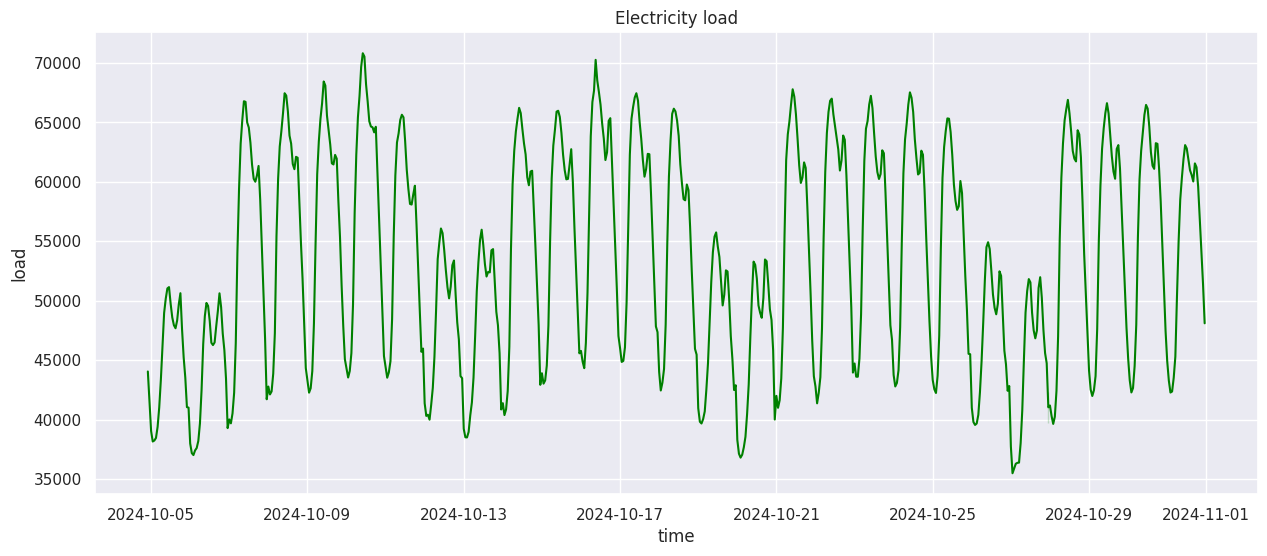

In [3]:
warnings.filterwarnings('ignore') # To ignore the warnings 
sns.set(style="darkgrid")
plt.figure(figsize=(15, 6))
sns.lineplot(x="time", y='load', data=data, color='green')
plt.title('Electricity load')
plt.xlabel('time')
plt.ylabel('load')
plt.show()

In [4]:
# Drop NaN values from rolling median
#data= data.dropna().reset_index(drop=True)
from statsmodels.tsa.seasonal import seasonal_decompose
# Assume 'data' is your original time series DataFrame
result = seasonal_decompose(data['load'], period=24, model='additive')
decomposed_df = pd.DataFrame({
    "time": data["time"],
    "load": data["load"],
    "trend": result.trend,
    "seasonal": result.seasonal,
    "residual": result.resid
})
decomposed_df = decomposed_df.dropna().reset_index(drop=True)
print(decomposed_df.head())  # Check if values exist

                 time      load         trend     seasonal     residual
0 2024-10-05 10:00:00  51043.00  45336.479167  9280.635912 -3574.115078
1 2024-10-05 11:00:00  51153.00  45238.119792  9042.062223 -3127.182015
2 2024-10-05 12:00:00  49758.25  45180.307292  7696.544744 -3118.602035
3 2024-10-05 13:00:00  48602.00  45138.026042  5943.586610 -2479.612652
4 2024-10-05 14:00:00  47953.00  45092.156250  4566.933766 -1706.090016


In [5]:
adjusted_result = seasonal_decompose(decomposed_df['residual'], period=24, model='additive')

In [6]:
resid_decomposed_df = pd.DataFrame({
    "time": decomposed_df["time"],
    "load": decomposed_df["load"],
    "trend": adjusted_result.trend,
    "seasonal": adjusted_result.seasonal,
    "residual":adjusted_result.resid
})
resid_decomposed_df = resid_decomposed_df.dropna().reset_index(drop=True)
print(resid_decomposed_df.head())  # Check if values exist

                 time      load       trend   seasonal     residual
0 2024-10-05 22:00:00  41061.00 -152.076280 -37.982807  3544.859696
1 2024-10-06 23:00:00  39298.00 -168.534831 -41.396281  4565.409405
2 2024-10-06 00:00:00  38006.50 -196.853950 -89.539261  5180.411168
3 2024-10-06 01:00:00  37193.75 -242.460829 -82.543621  5607.547848
4 2024-10-06 02:00:00  37030.50 -299.324653 -51.415736  5520.771767


In [7]:
#data["adjusted_load"] = data["load"] -(data["load"]).shift(24*7) # Remove daily seasonality
resid_decomposed_df["adjusted_residual"] = resid_decomposed_df["residual"]
# Convert 'time' to datetime if not already
resid_decomposed_df["time"] = pd.to_datetime(decomposed_df["time"])
# Extract the day of the week (0 = Monday, ..., 6 = Sunday)
resid_decomposed_df["weekday"] = decomposed_df["time"].dt.weekday
# Identify weekend days (Saturday=5, Sunday=6) for smoothing
weekend_mask = resid_decomposed_df["weekday"].isin([5, 6])
# Apply rolling median for weekends
resid_decomposed_df.loc[weekend_mask, 'adjusted_residual'] = resid_decomposed_df['adjusted_residual'].rolling(window=24*2, center=True).median()
# 🔹 Apply Monday Seasonality Removal# Step 1: Identify Mondays
resid_decomposed_df["monday"] = resid_decomposed_df["time"].dt.weekday  # 0 = Monday
monday_mask = resid_decomposed_df["monday"] == 0  # Boolean mask for Mondays

# Step 2: Apply expanding median *only on Mondays*
resid_decomposed_df.loc[monday_mask, 'adjusted_residual'] = (
    resid_decomposed_df.loc[monday_mask, 'adjusted_residual']
    .expanding(min_periods=1)
    .median()
)

# Step 3: Drop helper column if not needed
#data.drop(columns=["monday"], inplace=True)



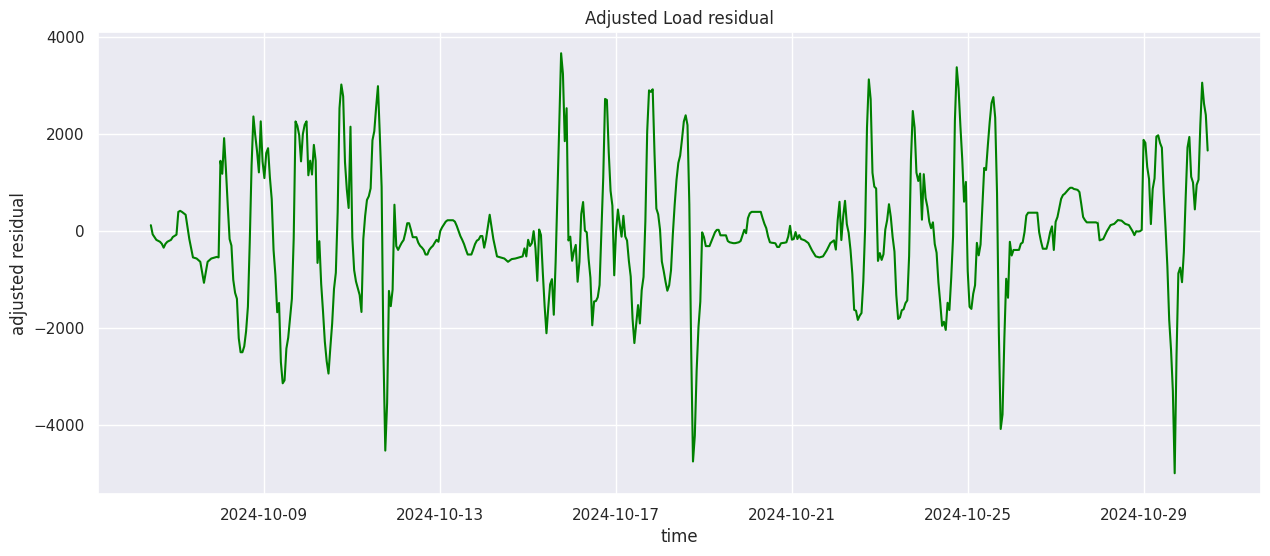

In [8]:
warnings.filterwarnings('ignore') # To ignore the warnings 
sns.set(style="darkgrid")
plt.figure(figsize=(15, 6))
sns.lineplot(x="time", y='adjusted_residual', data=resid_decomposed_df, color='green')
plt.title('Adjusted Load residual')
plt.xlabel('time')
plt.ylabel('adjusted residual')
plt.show()

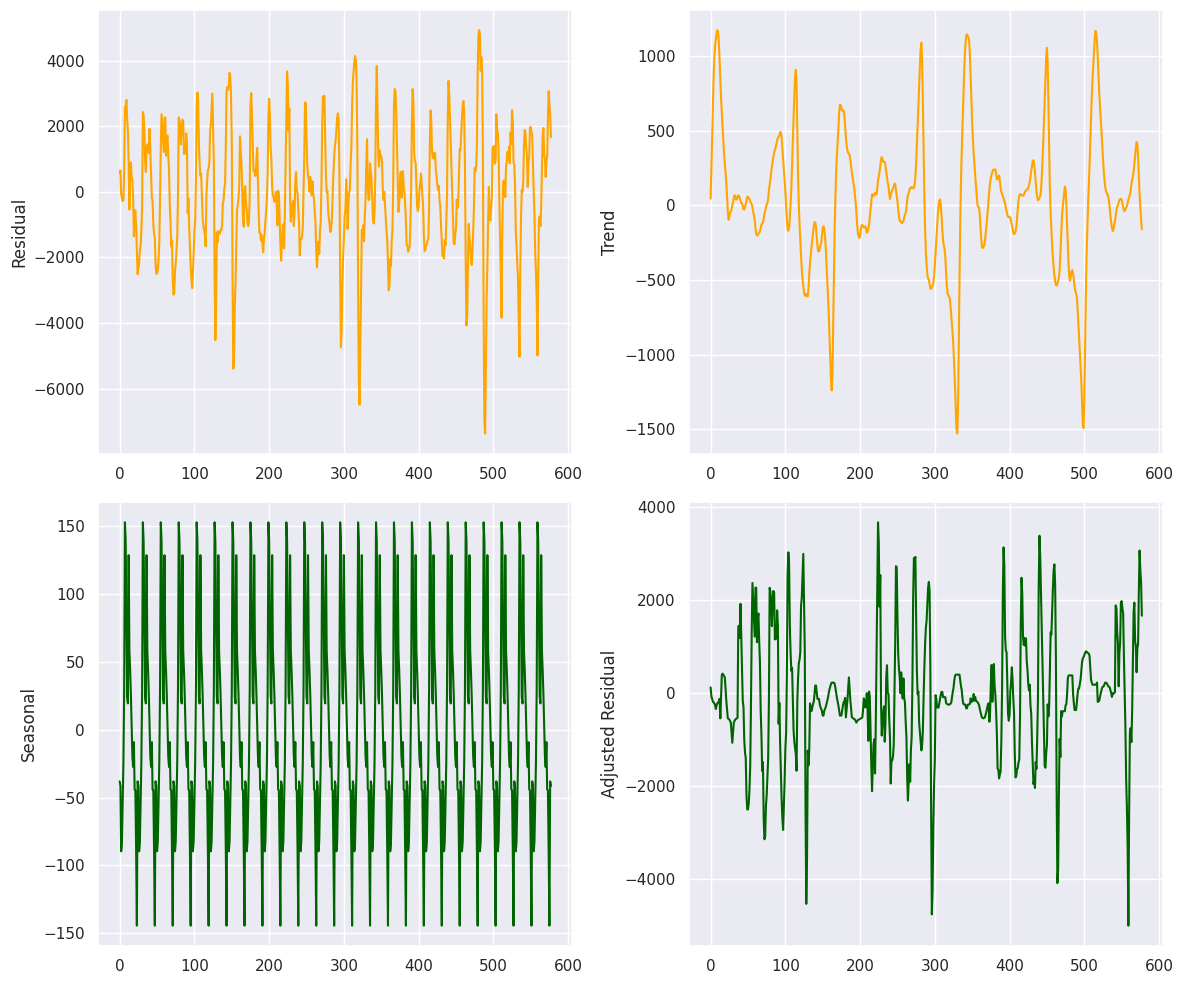

In [9]:
resid_decomposed_df= resid_decomposed_df.dropna().reset_index(drop=True)
# To create a 2x2 grid for the subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
resid_decomposed_df['residual'].plot(ax=ax1, color='orange')
ax1.set_ylabel('Residual')
resid_decomposed_df['trend'].plot(ax=ax2, color='orange')
ax2.set_ylabel('Trend')
resid_decomposed_df['seasonal'].plot(ax=ax3, color='darkgreen')
ax3.set_ylabel('Seasonal')
resid_decomposed_df['adjusted_residual'].plot(ax=ax4, color='darkgreen')
ax4.set_ylabel('Adjusted Residual')

plt.tight_layout()

plt.show()

In [10]:
# Compute cleaned load
decomposed_df["adjusted_load"] = decomposed_df['load'] + resid_decomposed_df["trend"]
decomposed_df = decomposed_df.dropna().reset_index(drop=True)
print(decomposed_df.head()) 

                 time      load         trend     seasonal     residual  \
0 2024-10-05 10:00:00  51043.00  45336.479167  9280.635912 -3574.115078   
1 2024-10-05 11:00:00  51153.00  45238.119792  9042.062223 -3127.182015   
2 2024-10-05 12:00:00  49758.25  45180.307292  7696.544744 -3118.602035   
3 2024-10-05 13:00:00  48602.00  45138.026042  5943.586610 -2479.612652   
4 2024-10-05 14:00:00  47953.00  45092.156250  4566.933766 -1706.090016   

   adjusted_load  
0   51088.223850  
1   51402.807726  
2   50198.009983  
3   49260.026584  
4   48807.117513  


In [11]:
result_adjusted_load = seasonal_decompose(decomposed_df['adjusted_load'], period=24, model='additive')
decomposed_adjusted_load = pd.DataFrame({
    "time": decomposed_df["time"],
    "load": decomposed_df["load"],
    "adjusted_load":decomposed_df["adjusted_load"],
    "trend":result_adjusted_load.trend,
    "seasonal": result_adjusted_load.seasonal,
    "residual":result_adjusted_load.resid
})
decomposed_adjusted_load = decomposed_adjusted_load.dropna().reset_index(drop=True)
print(decomposed_adjusted_load.head())  # Check if values exist

                 time      load  adjusted_load         trend      seasonal  \
0 2024-10-05 22:00:00  41061.00   42036.804036  44952.966485  -6817.660138   
1 2024-10-06 23:00:00  39298.00   40137.575846  44884.742739  -9447.476670   
2 2024-10-06 00:00:00  38006.50   38722.965929  44804.761479 -11108.506178   
3 2024-10-06 01:00:00  37193.75   37808.755317  44705.718770 -12165.269238   
4 2024-10-06 02:00:00  37030.50   37551.405816  44593.557337 -12027.834276   

      residual  
0  3901.497690  
1  4700.309777  
2  5026.710628  
3  5268.305784  
4  4985.682755  


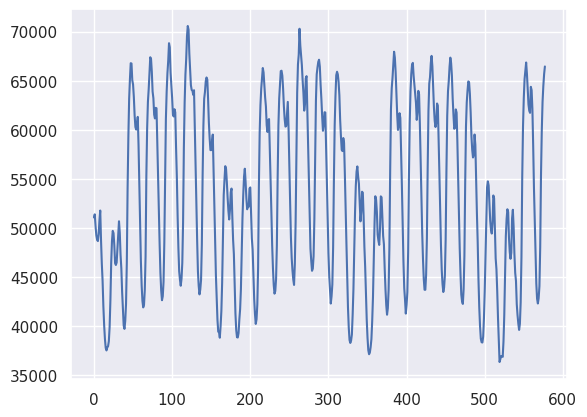

In [12]:
import matplotlib.pyplot as plt
plt.plot(decomposed_df['adjusted_load'])
plt.show()

In [13]:
# To ensure the correct column names
df = pd.DataFrame({'unique_id': [1] * len(decomposed_df), 'ds': decomposed_df["time"], 'load': decomposed_df['load'], 'adjusted_load': decomposed_df['adjusted_load']})


In [14]:
# we use x to split the data
x=(1-128/len(decomposed_df['adjusted_load']))
split_idx = int(len(df) * x)
# splitting the dataframe into train and test sets
train_df = df[:split_idx]
test_df = df[split_idx:]
print(train_df.shape, test_df.shape)
print(train_df.head())

(449, 4) (129, 4)
   unique_id                  ds      load  adjusted_load
0          1 2024-10-05 10:00:00  51043.00   51088.223850
1          1 2024-10-05 11:00:00  51153.00   51402.807726
2          1 2024-10-05 12:00:00  49758.25   50198.009983
3          1 2024-10-05 13:00:00  48602.00   49260.026584
4          1 2024-10-05 14:00:00  47953.00   48807.117513


In [15]:
# To load TimesFM pretrained checkpoints with hyperparameters
tfm = timesfm.TimesFm(
  hparams = timesfm.TimesFmHparams(
    context_len=512, # max 512, can be shorter
    horizon_len=128,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend="cpu", # ‘gpu’ when using GPU backend for fine-tuning
  ),
  checkpoint = timesfm.TimesFmCheckpoint(
    huggingface_repo_id="google/timesfm-1.0-200m-pytorch"
  )
)

Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 44462.59it/s]


In [16]:
# To generate forecasts using the TimesFM model on the given DataFrame
timesfm_forecast = tfm.forecast_on_df(
    inputs=train_df,           # Input DataFrame containing the time-series data for training
    freq="h",                  # Frequency of the time-series data (e.g., 'M' for monthly, 'D' for daily)
    value_name="adjusted_load",        # Name of the column containing the values to be forecasted
    num_jobs=-1,               # Number of parallel jobs to use for forecasting (-1 uses all available cores)
)


Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.


In [17]:
timesfm_forecast.head()

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,1,2024-10-25 00:00:00,50003.949219,48729.546875,49260.292969,49611.648438,49812.625000,50003.949219,50115.898438,50423.160156,50649.214844,51014.320312
1,1,2024-10-25 01:00:00,56175.468750,54417.097656,55105.671875,55626.257812,55851.078125,56175.468750,56481.527344,56837.441406,57153.023438,57637.156250
2,1,2024-10-25 02:00:00,61955.363281,59723.429688,60679.195312,61142.832031,61522.179688,61955.363281,62145.230469,62581.238281,63004.414062,63656.546875
3,1,2024-10-25 03:00:00,64859.398438,62905.515625,63649.335938,64204.804688,64510.984375,64859.398438,65168.453125,65456.937500,65853.257812,66487.476562
4,1,2024-10-25 04:00:00,65866.851562,64157.562500,64789.933594,65114.191406,65503.710938,65866.851562,65986.562500,66248.109375,66505.914062,67110.601562


In [18]:
test_df.head()

,unique_id,ds,load,adjusted_load
449,1,2024-10-24 03:00:00,44169.50,45161.007595
450,1,2024-10-24 04:00:00,47763.00,48818.332899
451,1,2024-10-24 05:00:00,54864.75,55823.748155
452,1,2024-10-24 06:00:00,60728.75,61417.154948
453,1,2024-10-24 07:00:00,63569.00,63938.088216


                     time      load  residual  pumped        date      Hour  \
51958 2024-10-04 22:00:00  44058.50  37932.25   31.00  04/10/2024  22:00:00   
51959 2024-10-05 23:00:00  41021.75  35589.50  304.50  05/10/2024  23:00:00   
51960 2024-10-05 00:00:00  39057.75  34160.25  469.75  05/10/2024  00:00:00   
51961 2024-10-05 01:00:00  38172.00  33830.25  388.75  05/10/2024  01:00:00   
51962 2024-10-05 02:00:00  38254.00  34484.50  652.25  05/10/2024  02:00:00   

       month  weekday  hour  
51958     10        4    23  
51959     10        5     0  
51960     10        5     1  
51961     10        5     2  
51962     10        5     3  


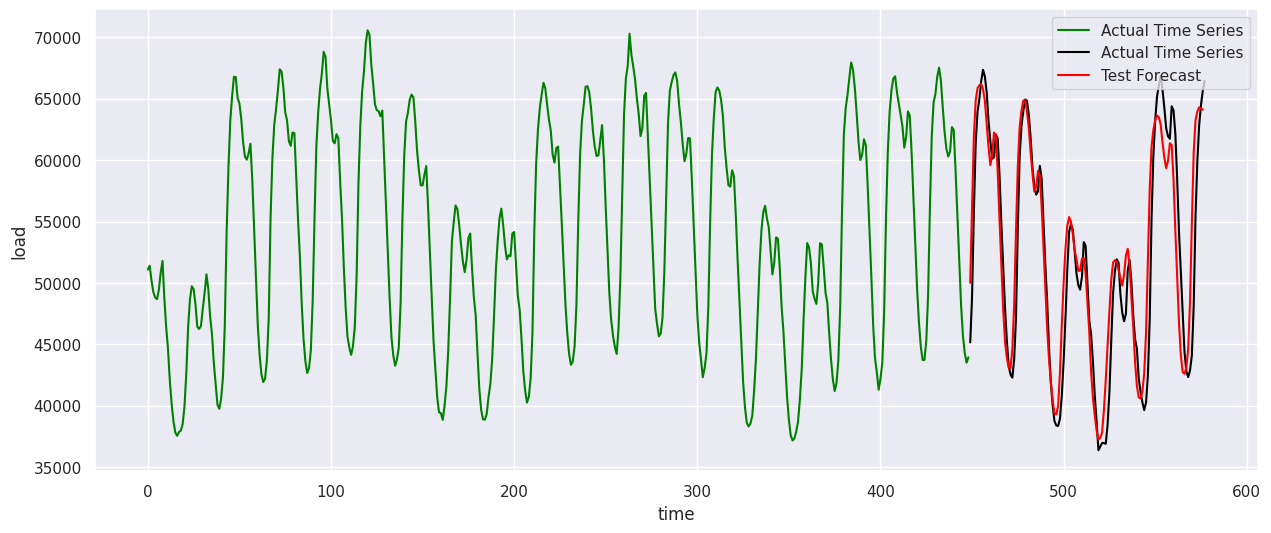

In [19]:
# Let's Visualise the Data
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
print(data.head())
warnings.filterwarnings('ignore') #Again to set the warnings to be ignored
# To set the style for seaborn
sns.set(style="darkgrid")
# Plot size
plt.figure(figsize=(15, 6))
L = len(train_df["adjusted_load"])
M = len(test_df["adjusted_load"])
N =L + M
P = len(timesfm_forecast["timesfm"])
Q = L + P
# Plot actual timeseries data
plt.plot(np.arange(L),train_df["adjusted_load"], color='green', label='Actual Time Series')# x="ds", 
plt.plot(np.arange(L,N),test_df["adjusted_load"], color='black', label='Actual Time Series')
# Plot forecasted value
plt.plot(np.arange(L,Q),timesfm_forecast["timesfm"], color='red', label='Test Forecast')
# Set plot title and labels
plt.ylabel('load')
plt.xlabel('time')
#plt.title('Electric Load: Actual vs Forecast')
# Show the legend
plt.legend()
plt.savefig('hourlyload forecast with Time FM.png')
# Display the plot
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# Step 6: Evaluate Performance
mse_test = mean_squared_error(test_df['load'][1:], timesfm_forecast['timesfm'])
mape_test = mean_absolute_percentage_error(test_df['load'][1:], timesfm_forecast['timesfm'])
print("Testing Mean Absolute Percentage Error (MAPE):", mape_test)

Testing Mean Absolute Percentage Error (MAPE): 0.02990692114414395
